In [14]:


from fastai.vision.all import *
from fastai.vision.gan import *


from PIL import ImageDraw, ImageFont

In [15]:
bs = 16

In [16]:


def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)



In [17]:


class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)



In [18]:
path = untar_data(URLs.PETS)

In [19]:


path_hr = path/'images'
path_lr = path/'crappy'



In [20]:


items = get_image_files(path_hr)



In [21]:
parallel(Crappifier(path_lr, path_hr), items);

In [22]:
bad_im = get_image_files(path_lr)

In [23]:


im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])



<AxesSubplot:>

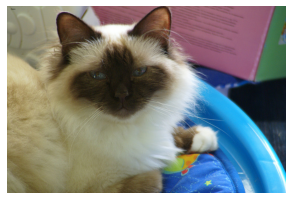

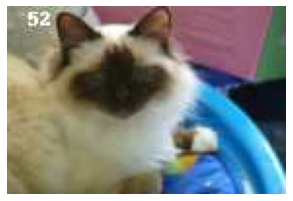

In [24]:
im1.show(); im2.show(figsize=(5,5))

In [25]:
dblock = DataBlock(
              blocks=(ImageBlock, ImageBlock),
              get_items=get_image_files,
              get_y = lambda x: path_hr/x.name,
              splitter=RandomSplitter(),
              item_tfms=Resize(224),
              batch_tfms=[*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)]
)

In [30]:


def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls



In [31]:


dls_gen = get_dls(bs, 128)


* The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)
* On the left will be our 'crappified' image, and the right our original



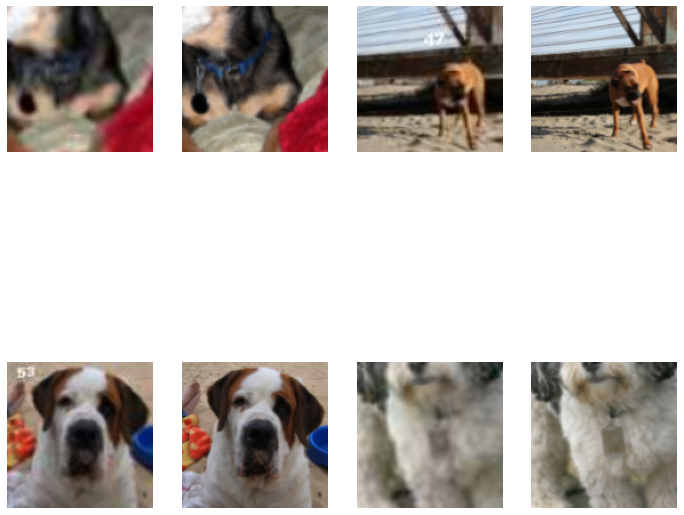

In [32]:


dls_gen.show_batch(max_n=4, figsize=(12,12))



In [33]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [34]:


learn_gen = unet_learner(
    dls_gen, 
    resnet34, 
    loss_func=loss_gen,
    blur=True, 
    norm_type=NormType.Weight, 
    self_attention=True,
    y_range=y_range
)



In [35]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.046539,0.047667,00:40
1,0.036004,0.036544,00:39


In [36]:
learn_gen.unfreeze()

In [37]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.035338,0.036417,00:42
1,0.033906,0.034958,00:42
2,0.032597,0.033368,00:42


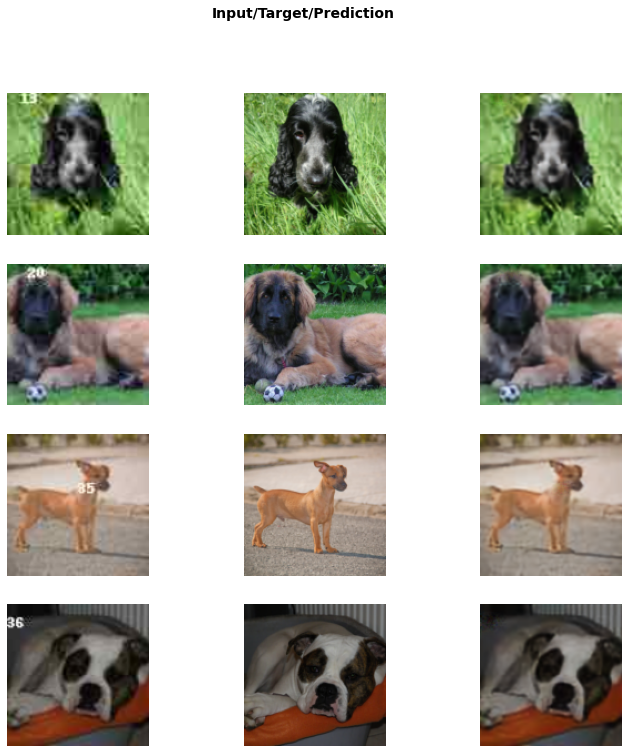

In [38]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [39]:
learn_gen.save('gen-pre2')

Path('/home/maquina1/.fastai/data/oxford-iiit-pet/models/gen-pre2.pth')

Now we need these generated images saved away so we can use them for our critic model. 

In [40]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [41]:
path_gen.mkdir(exist_ok=True)

In [42]:
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items
  
  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

We'll want to get rid of any augmentation, drop_last, and shuffle from our training DataLoader:

In [43]:
dl = dls_gen.train.new(
               shuffle=False, 
               drop_last=False, 
               after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
)

In [44]:
preds, _ = learn_gen.get_preds(dl=dl)

In [45]:
preds[0].shape

torch.Size([3, 128, 128])

In [46]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [47]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [48]:
arr = dec.numpy().transpose(1,2,0)

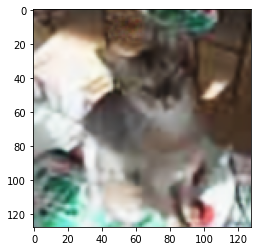

In [49]:
plt.imshow(arr.astype(np.uint8))

In [50]:
save_preds(dl, learn_gen)


## Training the critic

Now let's build our critic model


In [51]:
path_gen

Path('/home/maquina1/.fastai/data/oxford-iiit-pet/image_gen')

In [52]:
name_gen

'image_gen'

In [53]:
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [54]:
fnames[0]

Path('/home/maquina1/.fastai/data/oxford-iiit-pet/image_gen/Birman_100.jpg')

In [55]:
def get_crit_dls(fnames, bs:int, size:int):
  "Generate two `Critic` DataLoaders"
  splits = RandomSplitter(0.1)(fnames)
  dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
  tfms = [ToTensor(), Resize(size)]
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [56]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

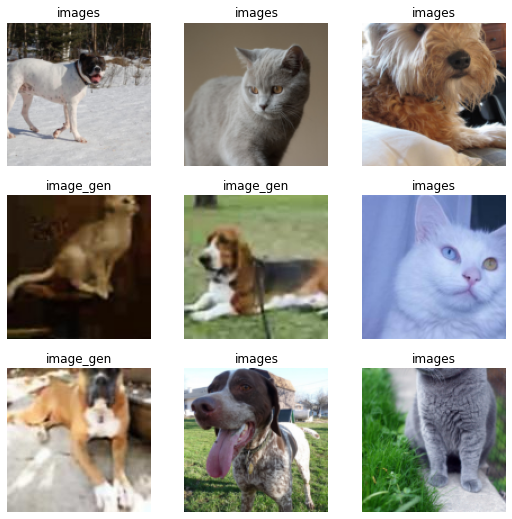

In [57]:
dls_crit.show_batch()

In [58]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [59]:
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [60]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [61]:
learn_crit.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.693940,0.693060,0.513816,01:16
1,0.667816,0.664692,0.564500,01:15
2,0.102409,0.058092,0.982112,01:16
3,0.040746,0.026279,0.995169,01:16
4,0.015843,0.011912,0.996273,01:16
5,0.011147,0.008928,0.996853,01:16


In [62]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')


## The GAN

Now we'll combine the two models together into a gan


In [63]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

In [64]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [65]:
## learn_gen = create_gen_learner().load('gen-pre2')

learn_gen = unet_learner(
    dls_gen, 
    resnet34, 
    loss_func=loss_gen,
    blur=True, 
    norm_type=NormType.Weight, 
    self_attention=True,
    y_range=y_range
).load('gen-pre2')



The last thing to do is to define our GAN. We are going to do this from_learners, and specifiy which is the generator and which is the critic. The switcher is a callback that decides when to switch from one to another.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.

The loss function of the critic is learn_crit's loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the learn_crit.loss_func on the fake image batch with a target of 1, and learn_gen.loss_func is applied to the output and target, batch of fake and batch of super-res images.


In [66]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [67]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [68]:
learn = GANLearner.from_learners(
           learn_gen, 
           learn_crit, 
           weights_gen=(1.,50.), 
           show_img=False,
           switcher=switcher,
           opt_func=partial(Adam, mom=0.), 
           cbs=GANDiscriminativeLR(mult_lr=5.)
)


In [69]:
lr = 1e-4

In [70]:
learn.fit(10, lr, wd=wd)

/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to a

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,3.353934,7.822271,7.822271,0.490451,01:22
1,3.319107,7.822270,7.822270,0.417775,01:23
2,3.290753,7.822271,7.822271,0.381580,01:23
3,3.403893,7.822270,7.822270,0.107732,01:23
4,3.426478,7.822271,7.822271,0.673794,01:23
5,3.282612,7.822271,7.822271,0.691531,01:23
6,3.359494,7.822272,7.822272,0.589809,01:23
7,3.275892,7.822271,7.822271,0.582093,01:23
8,3.422785,7.822270,7.822270,0.289128,01:23
9,3.320048,7.822270,7.822270,0.791816,01:23


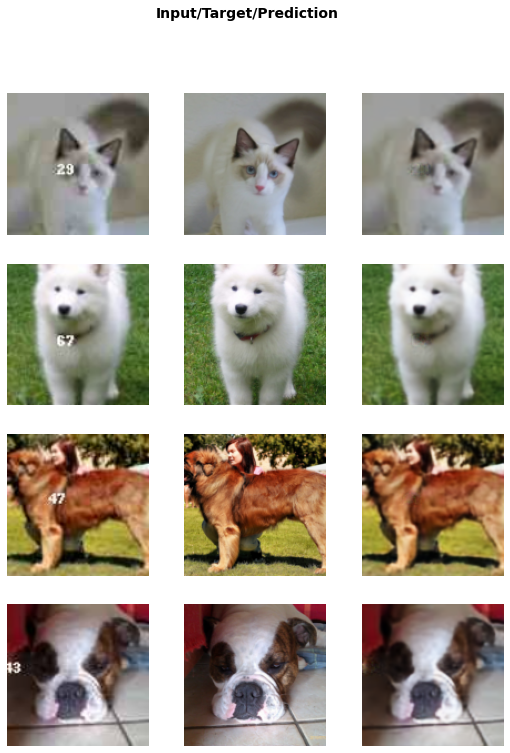

In [71]:
learn.show_results(max_n=4)